In [1]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.5184, 0.0753, 0.2895],
        [0.6520, 0.5913, 0.6170],
        [0.0377, 0.6701, 0.9233],
        [0.0259, 0.1297, 0.8092],
        [0.9337, 0.9013, 0.1645]])


In [2]:
import torch
torch.cuda.is_available()

True

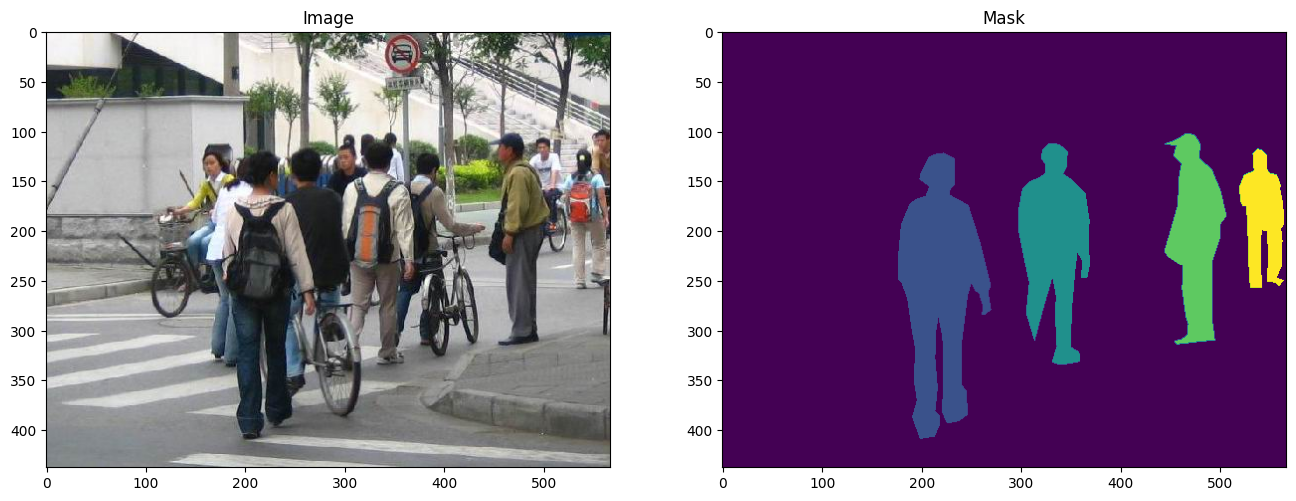

In [5]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [17]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.video import r3d_18, R3D_18_Weights

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\scdco/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


In [7]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\scdco/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100.0%


In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [9]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

1

In [19]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [22]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1919, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0844, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0179, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0082, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [33]:
from engine import train_one_epoch, evaluate
import utils


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 4

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
torch.save(model.state_dict(), 'trained_model.pth')

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:01:03  lr: 0.000090  loss: 3.8126 (3.8126)  loss_classifier: 0.5944 (0.5944)  loss_box_reg: 0.3804 (0.3804)  loss_mask: 2.7942 (2.7942)  loss_objectness: 0.0392 (0.0392)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.0566  data: 0.0466  max mem: 11385
Epoch: [0]  [10/60]  eta: 0:00:36  lr: 0.000936  loss: 1.5535 (2.0738)  loss_classifier: 0.4031 (0.3932)  loss_box_reg: 0.2003 (0.2464)  loss_mask: 1.0905 (1.4049)  loss_objectness: 0.0256 (0.0247)  loss_rpn_box_reg: 0.0039 (0.0046)  time: 0.7322  data: 0.0315  max mem: 11385
Epoch: [0]  [20/60]  eta: 0:00:27  lr: 0.001783  loss: 0.7003 (1.3845)  loss_classifier: 0.1648 (0.2866)  loss_box_reg: 0.1790 (0.2258)  loss_mask: 0.2867 (0.8495)  loss_objectness: 0.0072 (0.0161)  loss_rpn_box_reg: 0.0039 (0.0065)  time: 0.6737  data: 0.0280  max mem: 11385
Epoch: [0]  [30/60]  eta: 0:00:20  lr: 0.002629  loss: 0.5942 (1.1503)  loss_classifier: 0.1342 (0.2364)  loss_box_reg: 0.2368 (0.2502)  loss_mask: 0.2145 (0.6419)  loss

In [34]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())

# List all files in the current directory
print("Files in the current directory:", os.listdir('.'))



Current Working Directory: C:\torch_IZ4
Files in the current directory: ['.idea', 'coco_eval.py', 'coco_utils.py', 'engine.py', 'fasterrcnn_resnet50_fpn_no_train.ipynb', 'fasterrcnn_resnet50_fpn_trained.ipynb', 'main.py', 'model_training.ipynb', 'output', 'output_video.mp4', 'PennFudanPed', 'requirements.txt', 'trained_model.pth', 'transforms.py', 'utils.py', 'venv', 'vids']


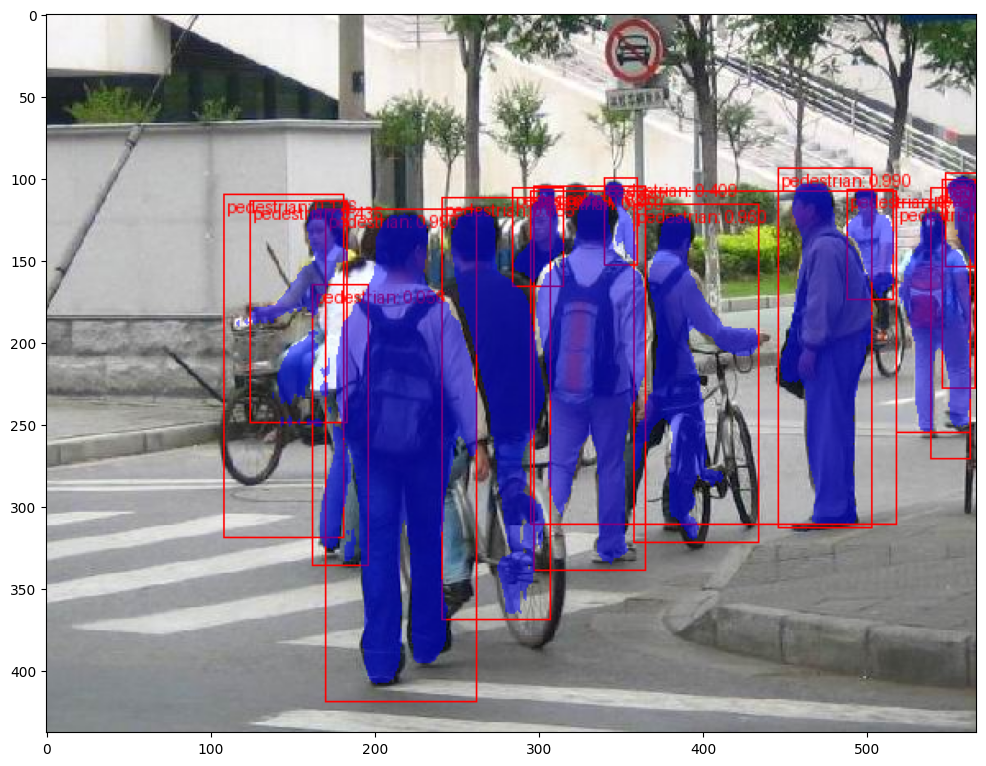

In [25]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [30]:
import cv2
import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_tensor
import time

# Load your trained model (assuming you have a function to do this)
model = get_model_instance_segmentation(num_classes)  # Replace with your model and class count
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Open the video
cap = cv2.VideoCapture('vids/pexels-keira-burton-6145681 (540p).mp4')  # Replace with your video path
if not cap.isOpened():
    raise Exception("Error opening video file")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output/output_video2.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

count_all_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Total frames: {count_all_frames}")

while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break
    
    time_counter_start = time.time()
    # Convert frame to tensor
    frame_tensor = to_tensor(frame).unsqueeze(0).to(device)

    # Model inference
    with torch.no_grad():
        predictions = model(frame_tensor)
        pred = predictions[0]

    # Convert the tensor to uint8 format
    frame_uint8 = frame_tensor[0].mul(255).to(torch.uint8)

    # Draw bounding boxes and segmentation masks on the frame
    pred_labels = [f"Label: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
    pred_boxes = pred["boxes"].long()
    processed_frame = draw_bounding_boxes(frame_uint8, pred_boxes, pred_labels, colors="red")
    masks = (pred["masks"] > 0.7).squeeze(1)
    processed_frame = draw_segmentation_masks(processed_frame, masks, alpha=0.5, colors="blue")

    # Convert tensor to numpy array for OpenCV
    processed_frame = processed_frame.permute(1, 2, 0).byte().numpy()

    # Write the processed frame
    out.write(processed_frame)
    time_counter_end = time.time()
    total_time = time_counter_end - time_counter_start
    fps = 1 / total_time
    print(f"Processed frame {count_all_frames}/{cap.get(1)}, Time: {total_time:.3f}, FPS: {fps:.3f}")
    # # Optionally display the frame (comment out if not needed)
    # cv2.imshow('Frame', processed_frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()


Total frames: 240
Processed frame 240/1.0, Time: 0.628, FPS: 1.592
Processed frame 240/2.0, Time: 0.418, FPS: 2.392
Processed frame 240/3.0, Time: 0.459, FPS: 2.177
Processed frame 240/4.0, Time: 0.457, FPS: 2.187
Processed frame 240/5.0, Time: 0.402, FPS: 2.489
Processed frame 240/6.0, Time: 0.399, FPS: 2.506
Processed frame 240/7.0, Time: 0.443, FPS: 2.257
Processed frame 240/8.0, Time: 0.452, FPS: 2.213
Processed frame 240/9.0, Time: 0.402, FPS: 2.487
Processed frame 240/10.0, Time: 0.416, FPS: 2.402
Processed frame 240/11.0, Time: 0.416, FPS: 2.404
Processed frame 240/12.0, Time: 0.411, FPS: 2.431
Processed frame 240/13.0, Time: 0.429, FPS: 2.330
Processed frame 240/14.0, Time: 0.397, FPS: 2.521
Processed frame 240/15.0, Time: 0.416, FPS: 2.401
Processed frame 240/16.0, Time: 0.388, FPS: 2.576
Processed frame 240/17.0, Time: 0.548, FPS: 1.824
Processed frame 240/18.0, Time: 0.408, FPS: 2.452
Processed frame 240/19.0, Time: 0.427, FPS: 2.342
Processed frame 240/20.0, Time: 0.405, FP